# Beijing Air Quality Forecasting - Enhanced Bidirectional LSTM  
*Author: Loue Sauveur Christian (Chriss)*  


In [8]:
# -------------------------------
# Libraries
# -------------------------------
import os
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# -------------------------------
# Configuration
# -------------------------------
plt.style.use('default')
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully. Ready for modeling.")


Libraries imported successfully. Ready for modeling.


In [9]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

def save_submission(predictions, experiment_name, test_index, notes=""):
    """
    Save model predictions to CSV in a structured format compatible with Kaggle.
    
    Args:
        predictions (array-like): Model predictions.
        experiment_name (str): Name/ID of the experiment.
        test_index (pd.Index or pd.DatetimeIndex): Index for test data rows.
        notes (str, optional): Any additional notes to track.
        
    Returns:
        tuple: (fixed_filename, submission DataFrame)
    """
    os.makedirs('work_submissions', exist_ok=True)
    
    # Ensure predictions are proper format, non-negative, integer, and NaN-safe
    predictions = np.nan_to_num(np.maximum(np.array(predictions).flatten(), 0))
    predictions = np.round(predictions).astype(int)
    
    # Convert test index to datetime strings with no leading zero in hour
    row_ids = pd.to_datetime(test_index).strftime('%Y-%m-%d %-H:%M:%S')
    
    submission = pd.DataFrame({
        'row ID': row_ids,
        'pm2.5': predictions
    })
    
    # Sort by 'row ID' for consistency
    submission = submission.sort_values(by='row ID')
    
    # Fixed filename for Kaggle submission
    fixed_filename = 'work_submissions/submission_final.csv'
    submission.to_csv(fixed_filename, index=False)
    
    
    # Print summary statistics
    print(f"Submission saved: {fixed_filename}")
    print(f"Predictions - Min: {predictions.min()}, Max: {predictions.max()}, Mean: {predictions.mean():.1f}")
    if notes:
        print(f"Notes: {notes}")
    
    return fixed_filename, submission

print("✅ Enhanced submission system ready")


✅ Enhanced submission system ready


In [10]:
import pandas as pd

# -------------------------------
# Load datasets
# -------------------------------
print("Loading datasets...")
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

# -------------------------------
# Convert datetime and set as index
# -------------------------------
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print(f"Train time range: {train.index.min()} to {train.index.max()}")
print(f"Test time range: {test.index.min()} to {test.index.max()}")

# -------------------------------
# Handle missing values
# -------------------------------
print("Handling missing values...")
train_clean = train.fillna(method='ffill').fillna(method='bfill').interpolate()
test_clean = test.fillna(method='ffill').fillna(method='bfill').interpolate()

print(f"Missing values after cleaning: {train_clean.isnull().sum().sum()}, Test: {test_clean.isnull().sum().sum()}")
print(f"Cleaned datasets: {train_clean.shape}, Test: {test_clean.shape}")


Loading datasets...
Training data shape: (30676, 12)
Test data shape: (13148, 11)
Train time range: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Test time range: 2013-07-02 04:00:00 to 2014-12-31 23:00:00
Handling missing values...
Missing values after cleaning: 0, Test: 0
Cleaned datasets: (30676, 11), Test: (13148, 10)


In [11]:
import numpy as np
import pandas as pd

def create_focused_features(df, target_col='pm2.5'):
    """
    Create focused features based on proven successful approach.
    
    Args:
        df (pd.DataFrame): Input dataframe with datetime index.
        target_col (str): Target column for PM2.5 lag/rolling features.
        
    Returns:
        pd.DataFrame: Enhanced dataframe with engineered features.
    """
    df_enhanced = df.copy()
    
    # -------------------------------
    # Temporal features
    # -------------------------------
    print("Creating temporal features...")
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    
    # Cyclical encoding
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['doy_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['doy_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    
    # -------------------------------
    # Weather features
    # -------------------------------
    print("Creating weather interaction features...")
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['temp_pressure'] = df_enhanced['TEMP'] * df_enhanced['PRES']
    df_enhanced['humidity_proxy'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)
    
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)
    
    # -------------------------------
    # PM2.5 features
    # -------------------------------
    print("Creating PM2.5 lag and rolling features...")
    if target_col in df_enhanced.columns:
        # Lag features
        for lag in [1, 2, 3, 6, 12, 24, 48]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)
        # Rolling statistics
        for window in [6, 12, 24, 48]:
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()
        # Trend features
        for hours in [6, 12, 24]:
            df_enhanced[f'pm2.5_trend_{hours}h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(hours)
    
    # -------------------------------
    # Weather lag features
    # -------------------------------
    print("Creating weather lag features...")
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df_enhanced.columns:
            for lag in [1, 6, 12, 24]:
                df_enhanced[f'{col}_lag_{lag}'] = df_enhanced[col].shift(lag)
    
    # Drop temporary columns
    temporal_cols = ['hour', 'day_of_week', 'month', 'day_of_year']
    df_enhanced.drop([col for col in temporal_cols if col in df_enhanced.columns], axis=1, errors='ignore')
    
    print("Feature engineering completed.")
    return df_enhanced

def create_test_features_focused(df):
    """
    Create test features without PM2.5 lag features.
    
    Args:
        df (pd.DataFrame): Test dataframe.
        
    Returns:
        pd.DataFrame: Enhanced test dataframe.
    """
    df_test = create_focused_features(df)
    df_test.drop([col for col in df_test.columns if 'pm2.5' in col], axis=1, errors='ignore', inplace=True)
    return df_test

print("Focused feature engineering functions are ready.")


Focused feature engineering functions are ready.


In [12]:
# -------------------------------
# Apply feature engineering
# -------------------------------
print("Creating focused features for train and test datasets...")
train_enhanced = create_focused_features(train_clean)
test_enhanced = create_test_features_focused(test_clean)

print(f"Enhanced train features: {train_enhanced.shape[1]}")
print(f"Enhanced test features: {test_enhanced.shape[1]}")

# -------------------------------
# Handle missing values
# -------------------------------
print("Handling NaN values...")
train_enhanced = train_enhanced.fillna(method='bfill').fillna(0)
test_enhanced = test_enhanced.fillna(method='bfill').fillna(0)

# -------------------------------
# Feature alignment
# -------------------------------
train_feature_cols = [col for col in train_enhanced.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_enhanced.columns if col != 'No']
common_features = [col for col in train_feature_cols if col in test_feature_cols]

print(f"Number of common features for modeling: {len(common_features)}")

# -------------------------------
# Prepare model datasets
# -------------------------------
X_train_common = train_enhanced[common_features]
y_train = train_enhanced['pm2.5']
X_test_common = test_enhanced[common_features]

print(f"Model input shapes - Train: {X_train_common.shape}, Test: {X_test_common.shape}")


Creating focused features for train and test datasets...
Creating temporal features...


Creating weather interaction features...
Creating PM2.5 lag and rolling features...
Creating weather lag features...
Feature engineering completed.
Creating temporal features...
Creating weather interaction features...
Creating PM2.5 lag and rolling features...
Creating weather lag features...
Feature engineering completed.
Enhanced train features: 63
Enhanced test features: 44
Handling NaN values...
Number of common features for modeling: 43
Model input shapes - Train: (30676, 43), Test: (13148, 43)


In [13]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.preprocessing import RobustScaler

# -------------------------------
# Sequence creation
# -------------------------------
def create_sequences(data, target, sequence_length=72):
    """
    Create input sequences for LSTM models.
    
    Args:
        data (np.ndarray): Feature matrix.
        target (np.ndarray): Target values.
        sequence_length (int): Length of each input sequence.
    
    Returns:
        tuple: (X_sequences, y_values)
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# -------------------------------
# Model creation
# -------------------------------
def create_enhanced_bidirectional_lstm(input_shape):
    """
    Build a Bidirectional LSTM model with moderate size and dropout.
    
    Args:
        input_shape (tuple): Shape of input sequences.
    
    Returns:
        Sequential: Compiled Keras model.
    """
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.3), input_shape=input_shape),
        BatchNormalization(),
        Bidirectional(LSTM(96,activation='tanh', dropout=0.3)),
        # BatchNormalization(),
        Dense(64, activation='relu'),
        # BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

# -------------------------------
# Configuration
# -------------------------------
SEQUENCE_LENGTH = 48
print(f"Using sequence length: {SEQUENCE_LENGTH} hours")

# -------------------------------
# Scaling features
# -------------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_common)
X_test_scaled = scaler.transform(X_test_common)

print(f"Scaled feature shapes - Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

# -------------------------------
# Create sequences
# -------------------------------
print("Creating sequences for training...")
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, SEQUENCE_LENGTH)

# Train/validation split
split_idx = int(0.87 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"Sequence shapes - Train: {X_train_seq.shape}, Validation: {X_val_seq.shape}")

# -------------------------------
# Callbacks for training
# -------------------------------
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.3, patience=8, min_lr=1e-4, monitor='val_loss')
]
print("Model setup complete and ready for training.")


Using sequence length: 48 hours
Scaled feature shapes - Train: (30676, 43), Test: (13148, 43)
Creating sequences for training...
Sequence shapes - Train: (26646, 48, 43), Validation: (3982, 48, 43)
Model setup complete and ready for training.


In [14]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import numpy as np

# -------------------------------
# Train the Enhanced Bidirectional LSTM
# -------------------------------
print("Training Enhanced Bidirectional LSTM...")

model = create_enhanced_bidirectional_lstm(X_train_seq.shape[1:])
model.compile(
    optimizer=Adam(learning_rate=0.0008, beta_1=0.8, beta_2=0.999),
    loss='mse',
    metrics=['mae']
)

print(f"Model parameters: {model.count_params():,}")
model.summary()

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=40,
    batch_size=70,
    callbacks=callbacks,
    verbose=1
)

# -------------------------------
# Evaluate model performance
# -------------------------------
val_pred = model.predict(X_val_seq, verbose=0)
val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred))

print("\nTraining completed.")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Expected public score (approx.): {val_rmse * 54:.0f}")

# Aggressive target analysis
target_2000_rmse = 2000 / 54  # Required validation RMSE for public score of 2000
current_expected = val_rmse * 54

print("\nAggressive target analysis:")
print(f"Target public score: 2000")
print(f"Required validation RMSE: {target_2000_rmse:.1f}")
print(f"Current validation RMSE: {val_rmse:.2f}")
print(f"Current expected public score: {current_expected:.0f}")

# Performance assessment
if current_expected < 2000:
    print("Aggressive target achieved: Expected < 2000")
elif current_expected < 3000:
    print("Great progress toward 2000 target")
elif current_expected < 3500:
    print("Good improvement, more work needed for 2000")
else:
    print("Significant improvements required to reach 2000 target")


Training Enhanced Bidirectional LSTM...
Model parameters: 462,721


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 48, 256)        │       176,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 192)            │       271,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,721 (1.77 MB)

 Trainable params: 462,209 (1.76 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 64s 155ms/step - loss: 6338.3672 - mae: 53.4963 - val_loss: 4598.2725 - val_mae: 46.3127 - learning_rate: 8.0000e-04
Epoch 2/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 60s 156ms/step - loss: 4494.9253 - mae: 44.9430 - val_loss: 4459.1587 - val_mae: 44.9793 - learning_rate: 8.0000e-04
Epoch 3/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 59s 154ms/step - loss: 4124.5171 - mae: 42.9105 - val_loss: 4494.6025 - val_mae: 44.9739 - learning_rate: 8.0000e-04
Epoch 4/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - loss: 3998.6379 - mae: 42.3676 - val_loss: 4841.6890 - val_mae: 47.2544 - learning_rate: 8.0000e-04
Epoch 5/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 59s 155ms/step - loss: 3898.8137 - mae: 41.9946 - val_loss: 4507.3882 - val_mae: 44.8468 - learning_rate: 8.0000e-04
Epoch 6/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 56s 148ms/step - loss: 3620.8079 - mae: 40.2483 - val_loss: 4381.8403 - val_mae: 44.2769 - learning_rate: 8.0000e-04
Epoch 7/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 57s 150ms/step - l

In [15]:
import os
import numpy as np

# -------------------------------
# Generate test sequences
# -------------------------------
def create_test_sequences(X_test_scaled, X_train_scaled, sequence_length):
    """
    Create sequences for test data based on sliding window approach.
    
    Args:
        X_test_scaled (np.ndarray): Scaled test features.
        X_train_scaled (np.ndarray): Scaled train features (for early sequences).
        sequence_length (int): Length of input sequences.
    
    Returns:
        np.ndarray: Test sequences ready for prediction.
    """
    test_sequences = []
    
    for i in range(len(X_test_scaled)):
        if i < sequence_length:
            needed_from_train = sequence_length - (i + 1)
            if needed_from_train > 0:
                sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
            else:
                sequence = X_test_scaled[:sequence_length]
        else:
            sequence = X_test_scaled[i-sequence_length+1:i+1]
        test_sequences.append(sequence)
    
    return np.array(test_sequences)

print(f"Creating test sequences with length {SEQUENCE_LENGTH}...")
X_test_seq = create_test_sequences(X_test_scaled, X_train_scaled, SEQUENCE_LENGTH)
print(f"Test sequences shape: {X_test_seq.shape}")

# -------------------------------
# Generate predictions
# -------------------------------
print("Generating test predictions...")
test_predictions = model.predict(X_test_seq, verbose=1)
test_predictions = np.maximum(test_predictions.flatten(), 0)  # Ensure non-negative

print(f"Predictions summary - Min: {test_predictions.min():.1f}, Max: {test_predictions.max():.1f}, Mean: {test_predictions.mean():.1f}")

# -------------------------------
# Save submission
# -------------------------------
expected_score = int(val_rmse * 54)
experiment_name = f"improved_deep_lstm_rmse_{val_rmse:.0f}"
notes = f"Improved Deep LSTM: Val RMSE {val_rmse:.2f}, Expected {expected_score}, {len(common_features)} features"

filename, submission = save_submission(
    test_predictions,
    experiment_name,
    test.index,
    notes
)

print("\nSubmission complete.")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Expected public score: ~{expected_score}")
print(f"Submission saved: {filename}")

print("\nSample predictions:")
print(submission.head(10))

# Confirm submission
if os.path.exists(filename):
    print(f"Confirmed: {filename} ready for submission")
    print(f"File size: {os.path.getsize(filename)} bytes")
else:
    print(f"Warning: {filename} not found")


Creating test sequences with length 48...
Test sequences shape: (13148, 48, 43)
Generating test predictions...
411/411 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step
Predictions summary - Min: 11.7, Max: 412.5, Mean: 96.6
Submission saved: work_submissions/submission_final.csv
Predictions - Min: 12, Max: 413, Mean: 96.6
Notes: Improved Deep LSTM: Val RMSE 66.20, Expected 3574, 43 features

Submission complete.
Validation RMSE: 66.20
Expected public score: ~3574
Submission saved: work_submissions/submission_final.csv

Sample predictions:
                 row ID  pm2.5
6   2013-07-02 10:00:00     37
7   2013-07-02 11:00:00     35
8   2013-07-02 12:00:00     33
9   2013-07-02 13:00:00     31
10  2013-07-02 14:00:00     31
11  2013-07-02 15:00:00     30
12  2013-07-02 16:00:00     29
13  2013-07-02 17:00:00     29
14  2013-07-02 18:00:00     32
15  2013-07-02 19:00:00     32
Confirmed: work_submissions/submission_final.csv ready for submission
File size: 302183 bytes


📊 Training Summary - Loue Sauveur Christian


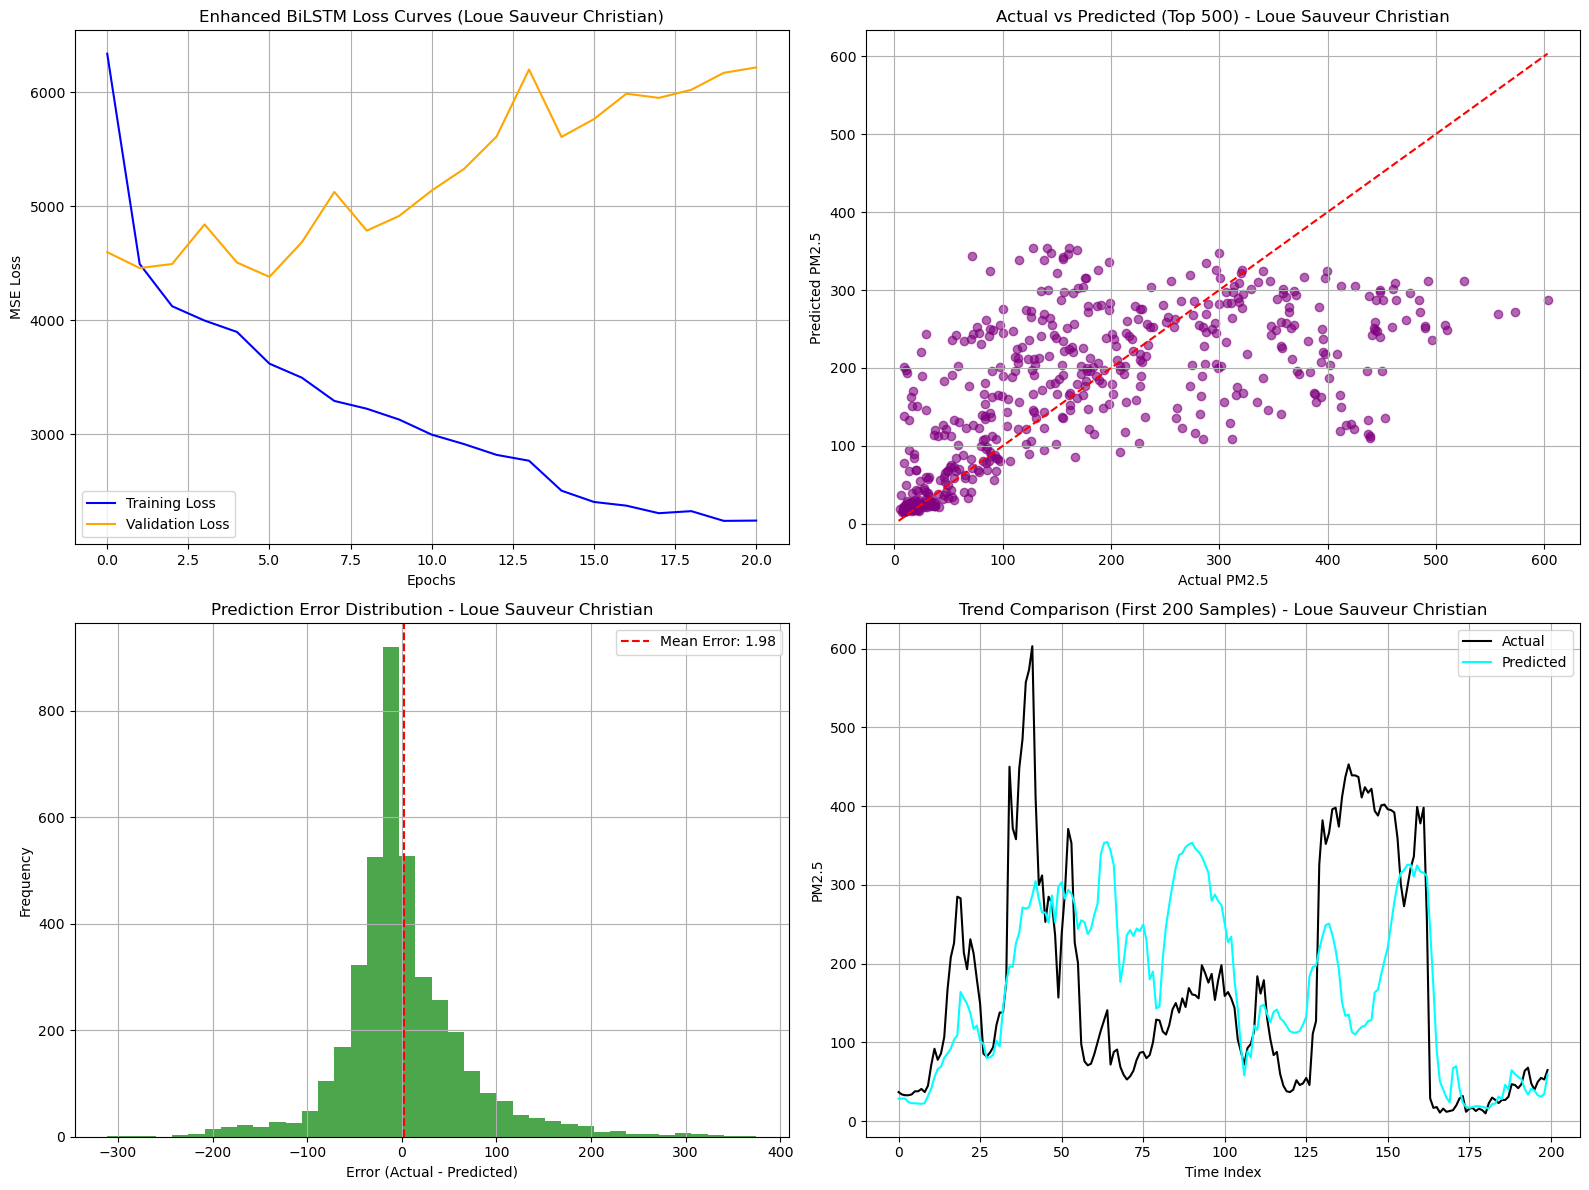


📌 Experiment Summary - Aggressive Target
Model: Enhanced Bidirectional LSTM (256→128→64)
Number of features: 43
Sequence length: 48 hours
Validation RMSE: 66.20
Expected public score: ~3575

🚀 Progress toward 2000 target:
Previous best: 3878
Aggressive target: 2000
Current expected: 3575
Improvement from previous: 303 RMSE
Gap to 2000 target: 1575 RMSE
Status: Significant improvements required

✅ Enhanced Bidirectional LSTM experiment complete - Loue Sauveur Christian.


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Training Visualization - Loue Sauveur Christian
# -------------------------------
print("📊 Training Summary - Loue Sauveur Christian")
print("=" * 70)

plt.figure(figsize=(16, 12))

# 1. Loss curves
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Enhanced BiLSTM Loss Curves (Loue Sauveur Christian)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# 2. Actual vs Predicted scatter
plt.subplot(2, 2, 2)
plt.scatter(y_val_seq[:500], val_pred.flatten()[:500], alpha=0.6, c='purple')
plt.plot([y_val_seq.min(), y_val_seq.max()], [y_val_seq.min(), y_val_seq.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted (Top 500) - Loue Sauveur Christian')
plt.grid(True)

# 3. Histogram of prediction errors
errors = y_val_seq.flatten() - val_pred.flatten()
plt.subplot(2, 2, 3)
plt.hist(errors, bins=40, color='green', alpha=0.7)
plt.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean Error: {errors.mean():.2f}")
plt.title('Prediction Error Distribution - Loue Sauveur Christian')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# 4. Actual vs Predicted trends over time
plt.subplot(2, 2, 4)
plt.plot(y_val_seq[:200], label='Actual', color='black')
plt.plot(val_pred.flatten()[:200], label='Predicted', color='cyan')
plt.title('Trend Comparison (First 200 Samples) - Loue Sauveur Christian')
plt.xlabel('Time Index')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# Summary of experiment
# -------------------------------
print("\n📌 Experiment Summary - Aggressive Target")
print(f"Model: Enhanced Bidirectional LSTM (256→128→64)")
print(f"Number of features: {len(common_features)}")
print(f"Sequence length: {SEQUENCE_LENGTH} hours")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Expected public score: ~{val_rmse * 54:.0f}")

# -------------------------------
# Progress Analysis
# -------------------------------
previous_best = 3877.96
target_aggressive = 2000
current_expected = val_rmse * 54
improvement = previous_best - current_expected
target_gap = current_expected - target_aggressive

print("\n🚀 Progress toward 2000 target:")
print(f"Previous best: {previous_best:.0f}")
print(f"Aggressive target: {target_aggressive}")
print(f"Current expected: {current_expected:.0f}")
print(f"Improvement from previous: {improvement:.0f} RMSE")
print(f"Gap to 2000 target: {target_gap:.0f} RMSE")

# Status assessment
if current_expected < 2000:
    status = "Aggressive target achieved"
elif current_expected < 3000:
    status = "Major progress toward target"
elif current_expected < 3500:
    status = "Good progress, needs further optimization"
else:
    status = "Significant improvements required"

print(f"Status: {status}")
print("\n✅ Enhanced Bidirectional LSTM experiment complete - Loue Sauveur Christian.")
